In [ ]:
!pip install fredapi

# Modeling VIX states via Markov Regime Switching Regression

This notebook contains three tests:

1. Estimating transition probabilities from data
2. Estimating transition probabilities plus prediction with Markov Regression
3. Estimating transition probabilities plus prediction with Markov Autoregression to account for autocorrelations

- **TODO**:
    * Clean, normalize, and build pandas dataframe
    * Construct training and test datasets
    * Figure out out-of-sample prediction and write function
    * Evaluate out-of-sample prediction accuracy
    * Set up testing metric by checking direction. We need a factor variable that encodes daily/weekly change for actual and predicted values. Then, we count good predictions. *If we get higher than 50% accuracy we can publish this lol.*
    * Ideally, we should try to modularize this code such that we can run it as a script.

## Data

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred

fred = Fred(api_key='aeca492c1d6b24a773fe1fb915779b96') # please don't share :)

# Define start and end dates
start_date = '2010-01-01'
end_date = '2023-01-01'

In [ ]:
## Fetching financial market data

# VIX is modeled as changes in value (i.e., first difference) in Prasad et al.
vix_data = yf.download('^VIX', start=start_date, end=end_date)['Close']

# Gold prices are modeled as log returns
gold_prices_data = yf.download('GC=F', start=start_date, end=end_date)['Close']

# Prasad et al. capture Crude oil effects via the CBOE Crude Oil ETF Volatility Index (^OVX) instead of actual prices (CL=F)
oil_etf_data = yf.download("^OVX", start=start_date, end=end_date)['Close']

# Crude oil prices are modeled as log returns as fetched weekly from FRED
oil_prices_data = yf.download('CL=F', start=start_date, end=end_date)['Close']

# USD index modeled as log returns in Prasad et al.
usd_index_data = yf.download('DX-Y.NYB', start=start_date, end=end_date)['Close']

# M2 data is fetched weekly from FRED
m2_data = fred.get_series('M2', observation_start=start_date, observation_end=end_date)

# St. Louis Fed financial stress index (FSI) is fetched weekly from FRED
fsi_data = fred.get_series('STLFSI4', observation_start=start_date, observation_end=end_date)

# Not seasonally adjusted (NSA) Initial Claims in Prasad et al. are fetched from FRED and modeled as log returns
initial_claims_data = fred.get_series('ICNSA', observation_start=start_date, observation_end=end_date)

# Fed funds rate data is converted to weekly
fed_rate_data = fred.get_series('DFF', observation_start=start_date, observation_end=end_date)

# A credit spread is the difference in yield between two bonds of similar maturity but different credit quality
# In Prasad et al. they construct it by differencing Moody’s Seasoned Baa corporate bond yield and Moody’s Seasoned Aaa corporate bond yield
AAA_bond_yield_data = fred.get_series('AAA', observation_start=start_date, observation_end=end_date)
BAA_bond_yield_data = fred.get_series('BAA', observation_start=start_date, observation_end=end_date)

# Calculate the credit spread
credit_spread_data = BAA_bond_yield_data - AAA_bond_yield_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


the credit spread leaves us with only 157 observations. These could be forward filled, but I am skeptical of interpolating so much. I don't know the details of what goes on with the data after such transformation.

Initial claims is claimed to be an reasoably important variable but it is a shitty time series. It is correlated (55%) with FSI and and more so with the OIL etf (65%). Also, FSI is higly correlated (~75%) with OIL etf. We must be cautious about multicollinearity issues.

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


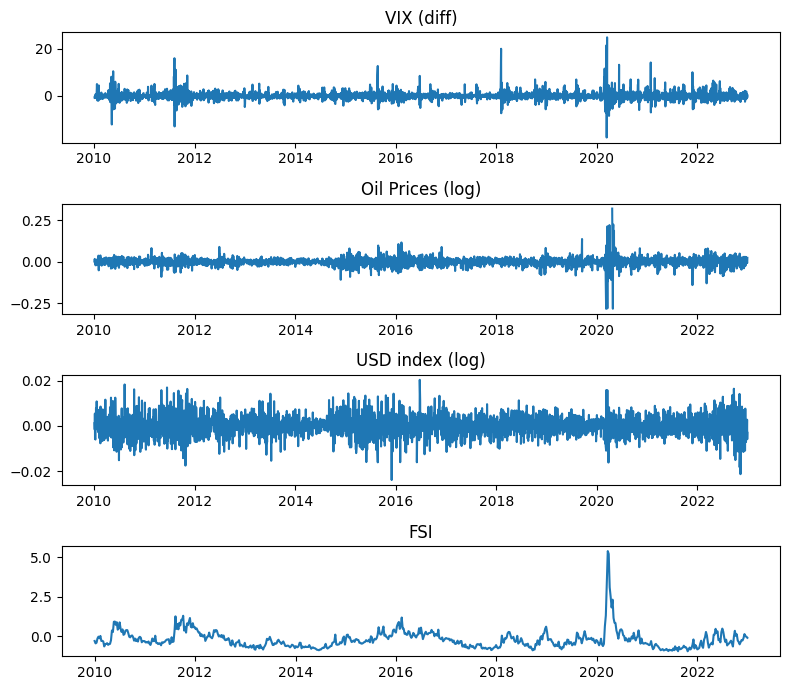

In [ ]:
def plot_transformed_variables(data_dict):
    """
    Plots each variable in the dictionary with its respective transformation.
    :param data_dict: Dictionary with keys as variable names and values as data series.
    """
    plt.figure(figsize=(8, 7))
    for i, (name, data) in enumerate(data_dict.items(), 1):
        plt.subplot(len(data_dict), 1, i)
        if 'log' in name:  # For log returns
            transformed_data = np.log(data / data.shift(1))
        elif 'diff' in name:  # For first differences
            transformed_data = data.diff()
        else:  # No transformation
            transformed_data = data

        plt.plot(transformed_data)
        plt.title(name)
        plt.tight_layout()

# Example Usage
data_dict = {
    'VIX (diff)': vix_data,
    'Oil Prices (log)': oil_prices_data,
    'USD index (log)': usd_index_data,
    "FSI": fsi_data
}
plot_transformed_variables(data_dict)

From Prasad et al.

> The daily data for the VIX Index is downloaded directly from the CBOE portal and does not have any missing values. Because the macro data belong to different departments, it is observed that the macro data is missing on a particular day, but the stock market might be functioning on the same day. In such a situation, the macro data are forward-filled. Moreover, daily macroeconomic variables might suffer from a delay in reporting the issue. To subside this issue, daily macroeconomic variables with delays in reporting issues were not selected in the study and the weekly macroeconomic variables, which are generally free from such issues, were also selected

Take a look at Table 1 and Table 2 in their [paper](file:///C:/Users/Bonoc/Downloads/jrfm-15-00126.pdf). It describes sources of data per macroeconomic variable and how it was constructed.

> For some features, in the cases where the log return or first difference needed to be computed, data are forward-filled after computing the log return or first difference. To accommodate the missing data properly, the timestamp of the VIX Index is taken as the base sequence and the data for the other features were forward-filled or, in case of additional data, were deleted after performing an inner join. The weekly data are considered in this study because the weekly data are free from delays in reporting issues. The log returns are computed for the features which have trend patterns, while the change in value is computed for the features which have a mean-reverting tendency.

In [ ]:
import pandas as pd

def construct_data_frame(vix_data, gold_prices_data, oil_etf_data, oil_prices_data,
                         usd_index_data, m2_data, fsi_data, initial_claims_data, fed_rate_data):
    # Convert all series to DataFrame with standard date index and resample to weekly
    weekly_data = {
        "VIX": vix_data.resample('W').last(),
        "Gold Prices": gold_prices_data.resample('W').last(),
        "Oil ETF": oil_etf_data.resample('W').last(),
        "Crude Oil Prices": oil_prices_data.resample('W').last(),
        "USD Index": usd_index_data.resample('W').last(),
        "M2": m2_data.resample('W').last(),
        "FSI": fsi_data.resample('W').last(),
        "Initial Claims": initial_claims_data.resample("W").last(),
        "Fed Rate": fed_rate_data.resample('W').last()
    }

    # Apply transformations
    weekly_data["Gold Prices"] = np.log(weekly_data["Gold Prices"] / weekly_data["Gold Prices"].shift(1))
    weekly_data["Crude Oil Prices"] = np.log(weekly_data["Crude Oil Prices"] / weekly_data["Crude Oil Prices"].shift(1))
    weekly_data["USD Index"] = np.log(weekly_data["USD Index"] / weekly_data["USD Index"].shift(1))
    weekly_data["VIX"] = weekly_data["VIX"].diff()

    # Merge datasets using outer join and then forward fill
    data_frame = pd.DataFrame(index=weekly_data["VIX"].index)
    for key, value in weekly_data.items():
        if value.name is None:
            value.name = key  # Set the name of the series to its key in the dictionary
        data_frame = pd.merge(data_frame, value, left_index=True, right_index=True, how='outer')

    # Forward fill missing values
    data_frame.ffill(inplace=True)

    return data_frame

# Example Usage
data_frame = construct_data_frame(vix_data, gold_prices_data, oil_etf_data, oil_prices_data, usd_index_data, m2_data, fsi_data, initial_claims_data, fed_rate_data)

<ipython-input-5-984d5f7b9851>:29: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Close_x'} in the result is deprecated and will raise a MergeError in a future version.
  data_frame = pd.merge(data_frame, value, left_index=True, right_index=True, how='outer')


In [ ]:
# Rename columns
data_frame.columns = ['VIX', 'Gold Prices', 'Oil ETF', 'Crude Oil Prices', 'USD Index', 'M2', 'FSI', 'Initial Claims (NSA)', 'Fed Rate']

# Check for missing values
print(data_frame.isna().sum())

# Statistical summary
print(data_frame.describe())

# Data Type Check
print(data_frame.dtypes)


VIX                     2
Gold Prices             2
Oil ETF                 1
Crude Oil Prices        2
USD Index               2
M2                      1
FSI                     0
Initial Claims (NSA)    0
Fed Rate                0
dtype: int64
              VIX  Gold Prices     Oil ETF  Crude Oil Prices   USD Index  \
count  677.000000   677.000000  678.000000        677.000000  677.000000   
mean     0.005229     0.000693   36.954912         -0.000045    0.000428   
std      3.480164     0.021668   16.709134          0.052402    0.010212   
min    -18.740002    -0.101316   14.500000         -0.346863   -0.044244   
25%     -1.600000    -0.011093   28.047501         -0.025303   -0.006081   
50%     -0.200000     0.001820   33.770000          0.002811    0.000531   
75%      1.280001     0.013248   42.380001          0.025345    0.006372   
max     23.030001     0.090090  190.080002          0.275756    0.040388   

                 M2         FSI  Initial Claims (NSA)    Fed Rate  


In [ ]:
data_frame[['Gold Prices', 'Crude Oil Prices', 'USD Index', 'FSI']].corr().style.background_gradient(cmap='coolwarm')

,Gold Prices,Crude Oil Prices,USD Index,FSI
Gold Prices,1.000000,0.157120,-0.465988,0.063736
Crude Oil Prices,0.157120,1.000000,-0.187025,-0.183289
USD Index,-0.465988,-0.187025,1.000000,0.054995
FSI,0.063736,-0.183289,0.054995,1.000000


In [ ]:
# drop first two rows of NaN
msar_data = data_frame.iloc[2:]
msar_data

,VIX,Gold Prices,Oil ETF,Crude Oil Prices,USD Index,M2,FSI,Initial Claims (NSA),Fed Rate
2010-01-17,-0.219999,-0.007142,29.799999,-0.059115,-0.001938,8444.3,-0.3959,659173.0,0.12
2010-01-24,9.400000,-0.036863,34.849998,-0.045373,0.012339,8448.0,-0.1270,507651.0,0.11
2010-01-31,-2.689999,-0.005708,34.049999,-0.022384,0.014962,8466.4,-0.0155,538617.0,0.12
2010-02-07,1.490000,-0.028852,39.990002,-0.023599,0.012258,8480.9,-0.1182,512463.0,0.13
2010-02-14,-3.380001,0.034836,36.040001,0.040468,-0.001493,8486.0,0.0308,482078.0,0.12
...,...,...,...,...,...,...,...,...,...
2022-12-04,-1.440001,0.024007,45.759998,0.047366,-0.013396,19366.0,-0.1082,287976.0,3.83
2022-12-11,3.770000,0.001224,46.930000,-0.118815,0.002484,19366.0,0.1462,250038.0,3.83
2022-12-18,-0.209999,-0.004515,42.290001,0.045015,-0.001050,19366.0,0.0102,248444.0,4.33
2022-12-25,-1.750000,0.003291,41.209999,0.068535,-0.003732,19366.0,-0.0155,269877.0,4.33


In [ ]:
# Check for missing values
print(msar_data.isna().sum())

# Statistical summary
print(msar_data.describe())

# Data Type Check
print(msar_data.dtypes)

VIX                     0
Gold Prices             0
Oil ETF                 0
Crude Oil Prices        0
USD Index               0
M2                      0
FSI                     0
Initial Claims (NSA)    0
Fed Rate                0
dtype: int64
              VIX  Gold Prices     Oil ETF  Crude Oil Prices   USD Index  \
count  677.000000   677.000000  677.000000        677.000000  677.000000   
mean     0.005229     0.000693   36.963205         -0.000045    0.000428   
std      3.480164     0.021668   16.720092          0.052402    0.010212   
min    -18.740002    -0.101316   14.500000         -0.346863   -0.044244   
25%     -1.600000    -0.011093   28.030001         -0.025303   -0.006081   
50%     -0.200000     0.001820   33.799999          0.002811    0.000531   
75%      1.280001     0.013248   42.380001          0.025345    0.006372   
max     23.030001     0.090090  190.080002          0.275756    0.040388   

                 M2         FSI  Initial Claims (NSA)    Fed Rate  


## Model

> **Consider up to 4 lags if daily model, only one week lag if weekly model.**

> Prasad et al. finds " The weekly model does not do well as compared to the daily model because the VIX Index tried to subside itself during a week’s time. From Figure 4 and Table A1, the previous week’s change in the value of the VIX Index is the most significant. The Financial Stress Index is a strong predictor. The Inflation rate, TED Spread, Fed Rate, M2 Money Supply, initial
unemployment claims, U.S. Dollar Index, Gold Price, Crude Oil Price, and CBOE Crude Oil ETF Volatility Index, in addition to the spread on fixed income securities, affect the VIX Index significantly but with lesser intensity."

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Modeling VIX states via Markov Regime Switching Regression

This notebook contains three tests:

1. Estimating transition probabilities from data
2. Estimating transition probabilities plus prediction with Markov Regression
3. Estimating transition probabilities plus prediction with Markov Autoregression to account for autocorrelations

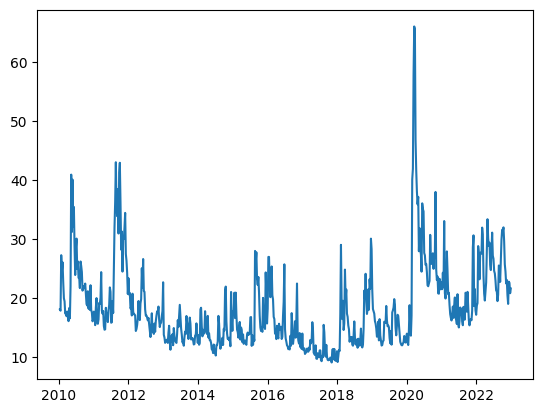

In [ ]:
plt.plot(vix_data.resample("W").last())

In [ ]:
endog = msar_data["VIX"]
exog = msar_data[['Gold Prices', 'Crude Oil Prices', 'USD Index', 'FSI']]
weekly_vix = vix_data.resample("W").last().iloc[1:]

vix_msar = sm.tsa.MarkovAutoregression(endog=weekly_vix,
                                         exog=exog,
                                         k_regimes=2, order=1,
                                         trend='c', switching_ar=False)

vix_msar_fit = vix_msar.fit()

print(vix_msar_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                         Markov Switching Model Results                         
Dep. Variable:                    Close   No. Observations:                  676
Model:             MarkovAutoregression   Log Likelihood               -1740.139
Date:                  Mon, 11 Dec 2023   AIC                           3500.277
Time:                          21:18:00   BIC                           3545.439
Sample:                      01-17-2010   HQIC                          3517.763
                           - 01-01-2023                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.8930      1.257     11.852      0.000      12.430      17.356
                             Regime 

In [ ]:
print(vix_msar_fit.summary().as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   &        Close         & \textbf{  No. Observations:  } &    676      \\
\textbf{Model:}           & MarkovAutoregression & \textbf{  Log Likelihood     } & -1740.139   \\
\textbf{Date:}            &   Mon, 11 Dec 2023   & \textbf{  AIC                } &  3500.277   \\
\textbf{Time:}            &       21:18:00       & \textbf{  BIC                } &  3545.439   \\
\textbf{Sample:}          &      01-17-2010      & \textbf{  HQIC               } &  3517.763   \\
\textbf{}                 &     - 01-01-2023     & \textbf{                     } &             \\
\textbf{Covariance Type:} &        approx        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
               & \textbf{coef} & \textbf{std err} & \textbf{z} & \textbf{P$> |$z$|$} & \textbf{[0.025} & \textbf{0.975]}  \\
\midrule
\textbf{const} &      14.8930  &        1.257     &    11.852  &         0.0

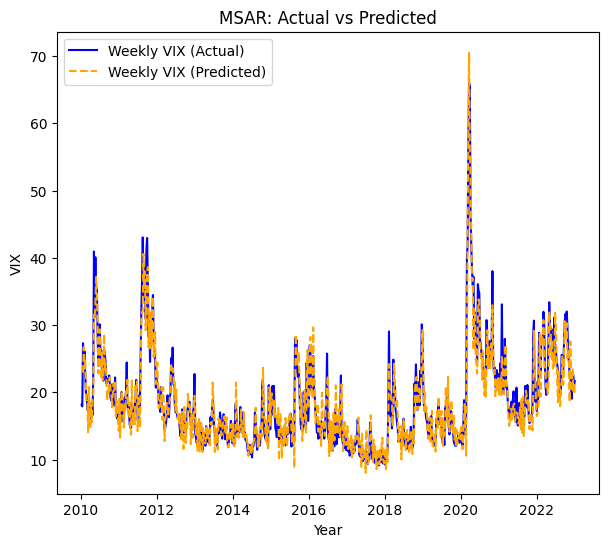

In [ ]:
plt.figure(figsize=(7,6))
plt.plot(vix_data.resample("W").last(), label="Weekly VIX (Actual)", color="blue")
plt.plot(vix_msar_fit.predict(), label="Weekly VIX (Predicted)",  linestyle='--', color='orange')
plt.title('MSAR: Actual vs Predicted')
plt.xlabel('Year')
plt.ylabel('VIX')
plt.legend()
plt.show()

In [ ]:
filtered_probs = vix_msar_fit.filtered_marginal_probabilities.iloc[-1]
transition_matrix = vix_msar_fit.regime_transition

print("Filtered Probabilities of the Last Observation:")
print(filtered_probs)
print("\nTransition Matrix:")
print(transition_matrix.round(4))

# we use the trnasition matrix and filtered probabilities for prediction
# Reshape the transition matrix from 3D to 2D
reshaped_transition_matrix = transition_matrix.reshape(2, 2)

# Predict the next state probabilities
next_state_probs = np.dot(reshaped_transition_matrix, filtered_probs)

print("\nPredicted State Probabilities for the Next Period:")
print(next_state_probs)

Filtered Probabilities of the Last Observation:
0    0.005339
1    0.994661
Name: 2023-01-01 00:00:00, dtype: float64

Transition Matrix:
[[[0.    ]
  [0.0721]]

 [[1.    ]
  [0.9279]]]

Predicted State Probabilities for the Next Period:
[0.07176427 0.92823573]


The high probability in the second regime (0.994661) for the last observation suggests that the model is quite confident about the regime the series was in at the end of the sample.

The predicted state probabilities for the next period (0.07176427 for regime 0 and 0.92823573 for regime 1) indicate the model's expectation that the series is more likely to stay in the same regime (regime 1).

In [ ]:
vix_msar_fit.params

p[0->0]     1.295074e-26
p[1->0]     7.214946e-02
const[0]    1.489302e+01
const[1]    1.980085e+01
x1[1]       1.698731e+01
x2[1]      -5.851315e+00
x3[1]       1.609426e+02
x4[1]       7.614433e+00
sigma2      7.904722e+00
ar.L1       8.309885e-01
dtype: float64

In [ ]:
weekly_vix.iloc[-5:]

Date
2022-12-04    19.059999
2022-12-11    22.830000
2022-12-18    22.620001
2022-12-25    20.870001
2023-01-01    21.670000
Freq: W-SUN, Name: Close, dtype: float64

In [ ]:
def MSAR_forecast(model, data, steps=1):
    """
    Forecast using a Markov Switching Autoregression model.

    :param model: A fitted MSAR model.
    :param data: DataFrame containing the exogenous variables for the last observation.
    :param steps: Number of steps to forecast.
    :return: A list containing the forecast for each step.
    """
    # Initialize predictions
    predictions = []

    # Extract parameters from the model
    mu1 = model.params['const[0]']
    mu2 = model.params['const[1]']

    # estimated coefficients of exogenous variables
    betas = model.params.drop(['const[0]', 'const[1]', 'sigma2', 'ar.L1', 'p[0->0]', 'p[1->0]']).values
    transMat = model.regime_transition

    # Latest observation for exogenous variables used
    last_obs = data.iloc[-1, [1, 3, 4, 6]].values

    # Initial regime probabilities
    state_probs = model.filtered_marginal_probabilities.iloc[-1]

    reshaped_transition_matrix = transMat.reshape(2, 2)

    # Forecasting loop
    for _ in range(steps):
        # Calculate regime predictions
        regime1_pred = mu1 + np.dot(betas, last_obs)
        regime2_pred = mu2 + np.dot(betas, last_obs)

        # Weighted sum of regime predictions
        weighted_pred = regime1_pred * state_probs[0] + regime2_pred * state_probs[1]
        predictions.append(weighted_pred)

        # Update state probabilities
        state_probs = np.dot(reshaped_transition_matrix, state_probs)

    return predictions

# Example Usage
# Assume 'msar_model' is your fitted MSAR model and 'msar_data' is your DataFrame with exogenous variables
forecasted_values = MSAR_forecast(vix_msar_fit, msar_data, steps=5)
print(forecasted_values)

[18.056462748666327, 17.730457655960603, 17.753978748042304, 17.752281713900523, 17.752404154001024]


In [ ]:
msar_data.iloc[-1, [1, 3, 4, 6]]

Gold Prices         0.013165
Crude Oil Prices    0.008760
USD Index          -0.007602
FSI                -0.087600
Name: 2023-01-01 00:00:00, dtype: float64

In [ ]:
vix_msar_fit.regime_transition

array([[[1.29507415e-26],
        [7.21494621e-02]],

       [[1.00000000e+00],
        [9.27850538e-01]]])

In [ ]:
vix_msar_fit.filtered_marginal_probabilities.iloc[-1].values

array([0.0053388, 0.9946612])

In [ ]:
vix_msar_fit.params

p[0->0]     1.295074e-26
p[1->0]     7.214946e-02
const[0]    1.489302e+01
const[1]    1.980085e+01
x1[1]       1.698731e+01
x2[1]      -5.851315e+00
x3[1]       1.609426e+02
x4[1]       7.614433e+00
sigma2      7.904722e+00
ar.L1       8.309885e-01
dtype: float64

# Simulations

s: 0
e: 50
s: 50
e: 80
s: 80
e: 170
s: 170
e: 205
s: 205
e: 260
s: 260
e: 300


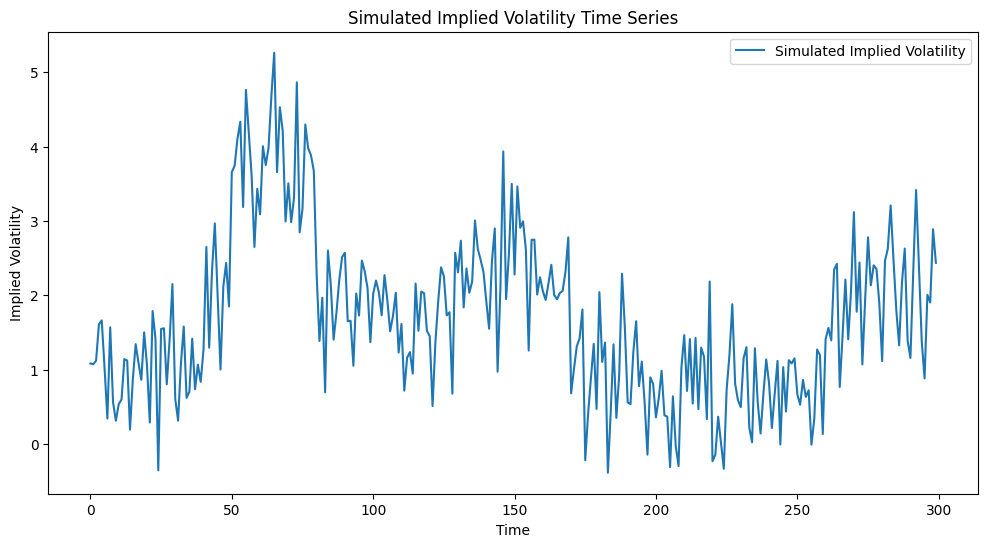

In [ ]:
np.random.seed(11272023)  # Set seed for reproducibility

# Parameters for the simulation
n = 300  # Number of observations
ar_coeffs = [0.25, -0.15, 0.2, 0.1]  # Coefficients for AR(4) process
white_noise_sd = 0.5  # Standard deviation of white noise

# Simulate the AR(4) process
y = np.zeros(n)
for t in range(4, n):
    y[t] = ar_coeffs[0] * y[t - 1] + ar_coeffs[1] * y[t - 2] + ar_coeffs[2] * y[t - 3] + ar_coeffs[3] * y[t - 4] + np.random.normal(0, white_noise_sd)

# Simulating additional independent variables
x1 = np.random.normal(0, 1, n)  # First additional variable
x2 = np.random.normal(0, 1, n)  # Second additional variable

# Making y influenced by x1 and x2
y += 0.3 * x1 - 0.2 * x2

# Adjusting regime changes to be more pronounced and persistent
regime_cutoffs = [50, 30, 90, 35, 55, 40]  # Durations of each regime
mean_levels = [1, 4, 2, 1, 1, 2]  # Mean levels for each regime

for i, duration in enumerate(regime_cutoffs):
    start_index = sum(regime_cutoffs[:i])
    print(f"s: {start_index}")
    end_index = start_index + duration
    y[start_index:end_index] += mean_levels[i]

plt.figure(figsize=(12, 6))
plt.plot(y, label='Simulated Implied Volatility')
plt.title('Simulated Implied Volatility Time Series')
plt.xlabel('Time')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

In [ ]:
data_full = pd.DataFrame({
    'IV': y,   # Implied Volatility
    'x1': x1,  # First additional variable
    'x2': x2   # Second additional variable
})

# Create lagged variables of the implied volatility for the AR(4) process
for i in range(1, 5):
    data_full[f'IV_lag_{i}'] = data_full['IV'].shift(i)

# Drop the initial rows with NaN values due to lagging
data_lagged = data_full.dropna()
data_lagged

,IV,x1,x2,IV_lag_1,IV_lag_2,IV_lag_3,IV_lag_4
4,1.663064,-0.686961,0.422227,1.608034,1.121637,1.072531,1.083882
5,1.022610,-0.272843,1.164097,1.663064,1.608034,1.121637,1.072531
6,0.342409,-0.077642,1.867437,1.022610,1.663064,1.608034,1.121637
7,1.570119,-0.027369,1.565371,0.342409,1.022610,1.663064,1.608034
8,0.561983,-0.216511,0.061803,1.570119,0.342409,1.022610,1.663064
...,...,...,...,...,...,...,...
295,0.882158,-1.619011,1.746030,1.382447,2.390658,3.416012,2.326811
296,2.006967,0.268655,1.240064,0.882158,1.382447,2.390658,3.416012
297,1.903276,-0.657786,-1.400041,2.006967,0.882158,1.382447,2.390658
298,2.887996,1.258226,-0.423870,1.903276,2.006967,0.882158,1.382447


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

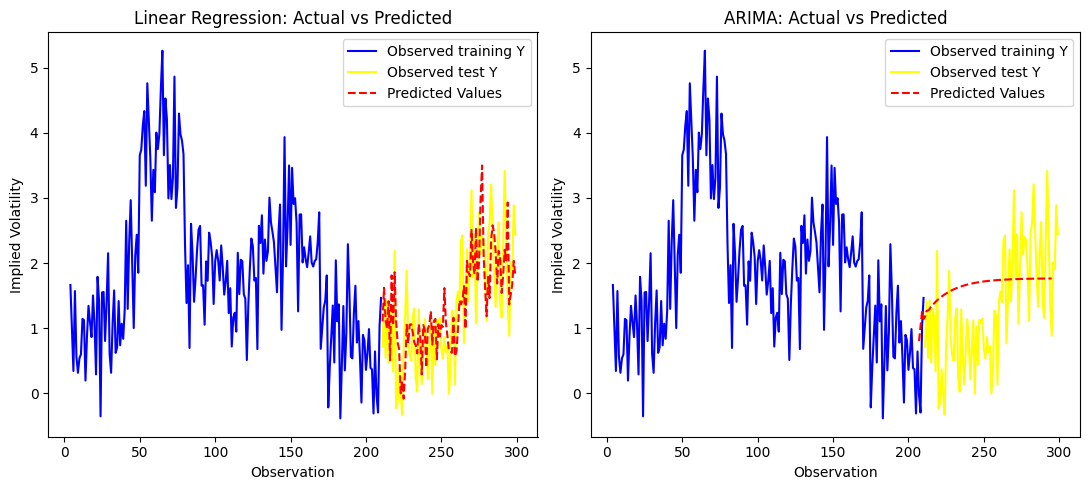

In [ ]:
def train_test_time_series_models(data, test_size, arima_order):
    """
    Trains Linear Regression and ARIMA models on a time series dataset and evaluates them on a test set.

    Parameters:
    data (DataFrame): The time series dataset with columns 'IV', 'x1', 'x2', and lagged 'IV' columns.
    test_size (float): The proportion of the dataset to include in the test split.
    arima_order (tuple): The order (p, d, q) of the ARIMA model.

    Returns:
    lr_model (RegressionResultsWrapper): The fitted Linear Regression model.
    arima_model (ARIMAResultsWrapper): The fitted ARIMA model.
    lr_predictions (ndarray): Predictions from the Linear Regression model for the test set.
    arima_predictions (ndarray): Predictions from the ARIMA model for the test set.
    """

    # Import necessary libraries
    import statsmodels.api as sm
    from statsmodels.tsa.arima.model import ARIMA
    import matplotlib.pyplot as plt

    # Split the data into training and test sets
    train_size = int(len(data) * (1 - test_size))
    train, test = data.iloc[:train_size], data.iloc[train_size:]

    # Prepare the training data for Linear Regression
    X_train = train[['x1', 'x2', 'IV_lag_1', 'IV_lag_2', 'IV_lag_3', 'IV_lag_4']]
    X_train = sm.add_constant(X_train)  # Add a constant term to the predictors
    y_train = train['IV']  # Dependent variable

    # Prepare the test data for Linear Regression
    X_test = test[['x1', 'x2', 'IV_lag_1', 'IV_lag_2', 'IV_lag_3', 'IV_lag_4']]
    X_test = sm.add_constant(X_test)  # Add a constant term to the predictors

    # Fit the Linear Regression model
    lr_model = sm.OLS(y_train, X_train).fit()

    # Prepare the training data for ARIMA
    y_arima_train = train['IV']  # Dependent variable for ARIMA

    # Fit the ARIMA model
    arima_model = ARIMA(y_arima_train, order=arima_order).fit()

    # Make predictions with both models
    lr_predictions = lr_model.predict(X_test)
    arima_predictions = arima_model.predict(start=train_size, end=len(data)-1)

    # Plot actual vs predicted values for the test set
    plt.figure(figsize=(11, 5))

    # Linear Regression Predictions
    plt.subplot(1, 2, 1)
    plt.plot(y_train, label="Observed training Y", color='blue')
    plt.plot(test["IV"], label="Observed test Y", color='yellow')
    plt.plot(lr_predictions, label='Predicted Values', color='red', linestyle='--')
    plt.title('Linear Regression: Actual vs Predicted')
    plt.xlabel('Observation')
    plt.ylabel('Implied Volatility')
    plt.legend()

    # ARIMA Model Predictions
    plt.subplot(1, 2, 2)
    plt.plot(y_train, label="Observed training Y", color='blue')
    plt.plot(test["IV"], label="Observed test Y", color='yellow')
    plt.plot(arima_predictions, label='Predicted Values', color='red', linestyle='--')
    plt.title('ARIMA: Actual vs Predicted')
    plt.xlabel('Observation')
    plt.ylabel('Implied Volatility')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return lr_model, arima_model, lr_predictions, arima_predictions

# Call the function with your dataset and parameters
lr_model, arima_model, lr_predictions, arima_predictions = train_test_time_series_models(
    data_lagged, test_size=0.3, arima_order=(4, 0, 0)
)


In [ ]:
print(f"MSR: {np.mean(lr_model.resid**2)}")
print(f"SSR: {sum(lr_model.resid**2)}")

MSR: 0.3314042468931267
SSR: 68.60067910687724


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/regime_switching/markov_switching.py:1291: EstimationWarning: Invalid regime transition probabilities estimated in EM iteration; probabilities have been re-scaled to continue estimation.
  warnings.warn('Invalid regime transition probabilities'


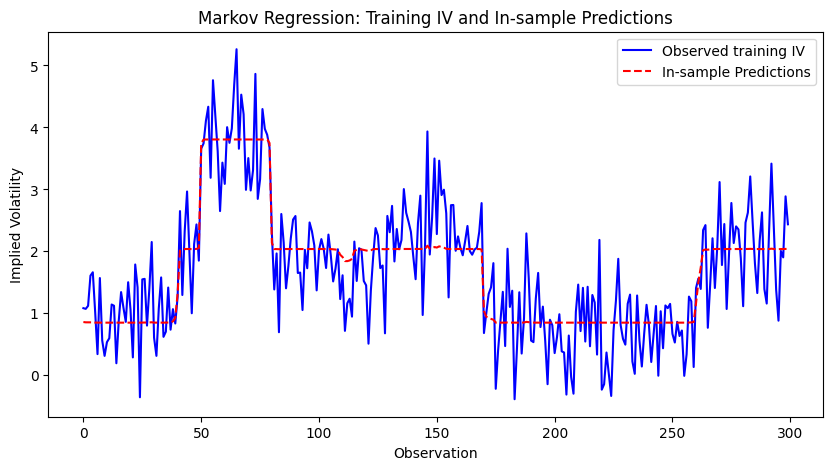

In [ ]:
# Fit the Markov Regression model
markov_model = sm.tsa.MarkovRegression(data_full["IV"], k_regimes=3, switching_variance=True).fit()

# Perform in-sample predictions. MarkovRegression does not support out-of-sample predictions
predictions = markov_model.predict()

# Plot observed training IV and in-sample predictions
plt.figure(figsize=(10, 5))
plt.plot(data_full['IV'], label="Observed training IV", color='blue')
plt.plot(predictions, label='In-sample Predictions', color='red', linestyle='--')
plt.title('Markov Regression: Training IV and In-sample Predictions')
plt.xlabel('Observation')
plt.ylabel('Implied Volatility')
plt.legend()

plt.show()

In [ ]:
filtered_probs = markov_model.filtered_marginal_probabilities.iloc[-1]
transition_matrix = markov_model.regime_transition

print("Filtered Probabilities of the Last Observation:")
print(filtered_probs)
print("\nTransition Matrix:")
print(transition_matrix.round(4))

# we use the trnasition matrix and filtered probabilities for prediction
# Reshape the transition matrix from 3D to 2D
reshaped_transition_matrix = transition_matrix.reshape(3, 3)

# Predict the next state probabilities
next_state_probs = np.dot(reshaped_transition_matrix, filtered_probs)

print("\nPredicted State Probabilities for the Next Period:")
print(next_state_probs)

# It shows persistency as expected. Series is more likely to persist in the current regime

Filtered Probabilities of the Last Observation:
0    0.618272
1    0.010431
2    0.371297
Name: 299, dtype: float64

Transition Matrix:
[[[0.5296]
  [0.7813]
  [0.    ]]

 [[0.    ]
  [0.0793]
  [1.    ]]

 [[0.4704]
  [0.1394]
  [0.    ]]]

Predicted State Probabilities for the Next Period:
[0.33561136 0.37212416 0.29226448]


In [ ]:
# and for the 3 regime case
armodel_3r = sm.tsa.MarkovAutoregression(data_full["IV"], exog=data_full[['x1', 'x2']],
                                         k_regimes=3, order=1, trend='c', switching_ar=False)

armodel_3r_fit = armodel_3r.fit()

print(armodel_3r_fit.summary())

                         Markov Switching Model Results                         
Dep. Variable:                       IV   No. Observations:                  299
Model:             MarkovAutoregression   Log Likelihood                -261.927
Date:                  Mon, 11 Dec 2023   AIC                            549.855
Time:                          21:18:15   BIC                            597.960
Sample:                               0   HQIC                           569.109
                                  - 299                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0853      0.339      3.199      0.001       0.420       1.750
                             Regime 

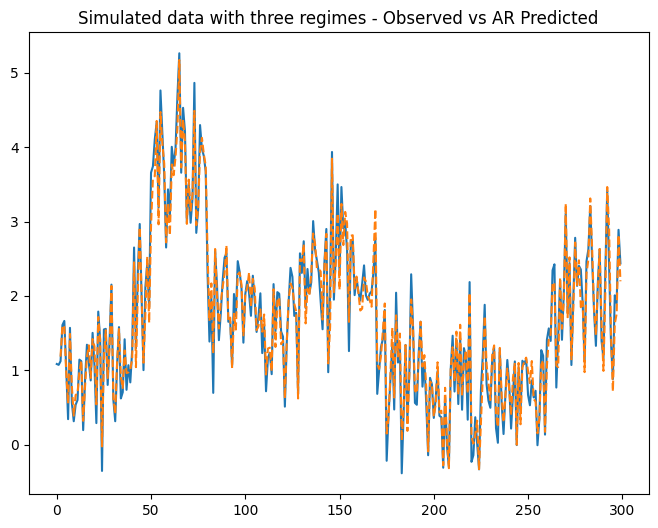

In [ ]:
predictions_ar3 = armodel_3r_fit.predict()

plt.figure(figsize=(8,6))
plt.plot(data_full["IV"], label='observed')
plt.plot(predictions_ar3, label='predicted',linestyle='dashed')
plt.title("Simulated data with three regimes - Observed vs AR Predicted")
plt.show()